# spark-bestfit Bounded Distribution Fitting Demo

This notebook demonstrates **bounded (truncated) distribution fitting** for data with natural constraints.

Use cases:
- **Percentages** (0-100 or 0-1)
- **Prices** (non-negative)
- **Ages** (0 to ~120)
- **Scores** (e.g., credit scores 300-850)
- **Count ranges** (e.g., items per order 1-100)

Key features:
- Auto-detect bounds from data min/max
- Explicit bounds for domain knowledge
- Samples always respect bounds
- Works with both continuous and discrete distributions

## Setup

In [1]:
import numpy as np
from pyspark.sql import SparkSession

# Create Spark session
spark = (
    SparkSession.builder
    .appName("Bounded-Distribution-Demo")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/01 21:44:13 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/01 21:44:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


26/01/01 21:44:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


26/01/01 21:44:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark version: 4.1.0


In [2]:
from spark_bestfit import DistributionFitter, DiscreteDistributionFitter

---

# Part 1: Continuous Bounded Fitting

For continuous data with natural bounds (percentages, prices, etc.).

## 1.1 Generate Bounded Data

Simulate percentage data that should be constrained to [0, 100].

In [3]:
np.random.seed(42)

# Simulate conversion rates (percentages between 0 and 100)
# Using beta distribution scaled to [0, 100]
percentage_data = np.random.beta(2, 5, size=10_000) * 100
df_pct = spark.createDataFrame([(float(x),) for x in percentage_data], ["conversion_rate"])

print(f"Percentage data: {len(percentage_data):,} samples")
print(f"  Min: {percentage_data.min():.2f}%")
print(f"  Max: {percentage_data.max():.2f}%")
print(f"  Mean: {percentage_data.mean():.2f}%")

Percentage data: 10,000 samples
  Min: 0.07%
  Max: 83.59%
  Mean: 28.52%


## 1.2 Auto-Detect Bounds

When `bounded=True`, bounds are automatically detected from data min/max.

In [4]:
fitter = DistributionFitter(spark)

# Auto-detect bounds from data
print("Fitting with auto-detected bounds...")
results_auto = fitter.fit(
    df_pct,
    column="conversion_rate",
    bounded=True,  # Enable bounded fitting
    max_distributions=10,
)

best_auto = results_auto.best(n=1)[0]
print(f"\nBest distribution: {best_auto.distribution}")
print(f"Auto-detected bounds: [{best_auto.lower_bound:.2f}, {best_auto.upper_bound:.2f}]")

Fitting with auto-detected bounds...



Best distribution: beta
Auto-detected bounds: [0.07, 83.59]


## 1.3 Explicit Bounds

For domain knowledge, specify bounds explicitly. This is useful when:
- You know the theoretical limits (percentages are 0-100)
- Your sample doesn't cover the full range
- You want to enforce business rules

In [5]:
# Explicit bounds: percentages must be 0-100
print("Fitting with explicit bounds [0, 100]...")
results_explicit = fitter.fit(
    df_pct,
    column="conversion_rate",
    bounded=True,
    lower_bound=0.0,    # Percentages can't be negative
    upper_bound=100.0,  # Percentages can't exceed 100
    max_distributions=10,
)

best_explicit = results_explicit.best(n=1)[0]
print(f"\nBest distribution: {best_explicit.distribution}")
print(f"Bounds: [{best_explicit.lower_bound:.2f}, {best_explicit.upper_bound:.2f}]")

Fitting with explicit bounds [0, 100]...



Best distribution: beta
Bounds: [0.00, 100.00]


## 1.4 Partial Bounds (One-Sided)

Specify only one bound when the other is unlimited.

In [6]:
# Simulate price data (non-negative)
price_data = np.random.exponential(scale=50, size=5_000)
df_price = spark.createDataFrame([(float(x),) for x in price_data], ["price"])

# Lower bound only: prices must be >= 0
print("Fitting prices with lower_bound=0 (upper auto-detected)...")
results_price = fitter.fit(
    df_price,
    column="price",
    bounded=True,
    lower_bound=0.0,  # Prices can't be negative
    # upper_bound not specified - auto-detected from data
    max_distributions=10,
)

best_price = results_price.best(n=1)[0]
print(f"\nBest distribution: {best_price.distribution}")
print(f"Bounds: [{best_price.lower_bound:.2f}, {best_price.upper_bound:.2f}]")

Fitting prices with lower_bound=0 (upper auto-detected)...



Best distribution: beta
Bounds: [0.00, 502.66]


## 1.5 Sampling Respects Bounds

The key benefit: samples from bounded distributions never exceed the bounds.

In [7]:
# Sample from the bounded distribution
samples = best_explicit.sample(size=10_000, random_state=42)

print(f"Generated {len(samples):,} samples from bounded {best_explicit.distribution}")
print(f"\nSample statistics:")
print(f"  Min: {samples.min():.4f} (bound: {best_explicit.lower_bound})")
print(f"  Max: {samples.max():.4f} (bound: {best_explicit.upper_bound})")
print(f"  Mean: {samples.mean():.2f}")

# Verify all samples are within bounds
within_bounds = (samples >= best_explicit.lower_bound).all() and (samples <= best_explicit.upper_bound).all()
print(f"\nAll samples within bounds: {within_bounds}")

Generated 10,000 samples from bounded beta

Sample statistics:
  Min: 0.4469 (bound: 0.0)
  Max: 88.5541 (bound: 100.0)
  Mean: 28.39

All samples within bounds: True


## 1.6 Visualization

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

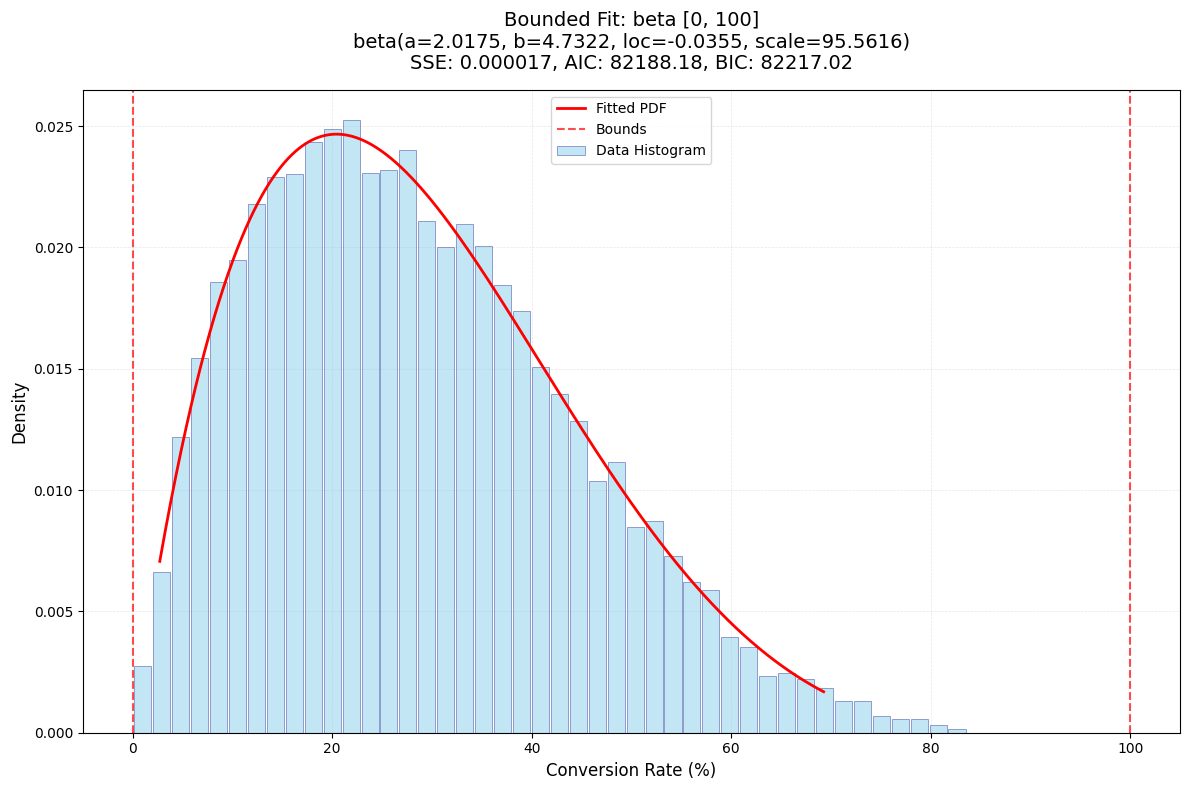

In [9]:
# Plot bounded fit
fig, ax = fitter.plot(
    best_explicit,
    df_pct,
    "conversion_rate",
    title=f"Bounded Fit: {best_explicit.distribution} [0, 100]",
    xlabel="Conversion Rate (%)",
    ylabel="Density",
    figsize=(12, 8),
)

# Add vertical lines at bounds
ax.axvline(best_explicit.lower_bound, color='red', linestyle='--', alpha=0.7, label='Bounds')
ax.axvline(best_explicit.upper_bound, color='red', linestyle='--', alpha=0.7)
ax.legend()
plt.show()

## 1.7 Compare: Unbounded vs Bounded Sampling

The key benefit of bounded fitting: **samples never exceed natural limits**.

When data is bounded (like test scores 0-100) but you fit an unbounded distribution 
(like normal), samples can exceed the valid range. This is problematic for:
- Simulation/monte carlo that requires valid values
- Downstream systems that expect values within bounds
- Data quality validation

Below we demonstrate this with test score data:

In [10]:
# To demonstrate bounded vs unbounded, we need data where unbounded fitting
# would select a distribution with INFINITE support (like normal).
# Beta-distributed data naturally fits beta, which has finite support.

# Let's use normally-distributed test scores (bell-shaped, bounded to [0, 100])
np.random.seed(123)
test_scores = np.random.normal(70, 15, size=10_000)
test_scores = np.clip(test_scores, 0, 100)  # Real test scores are bounded
df_scores = spark.createDataFrame([(float(x),) for x in test_scores], ["test_score"])

print("Test score data (clipped normal):")
print(f"  Min: {test_scores.min():.1f}, Max: {test_scores.max():.1f}, Mean: {test_scores.mean():.1f}")

# Create a fitter that EXCLUDES beta to force selection of infinite-support distributions
fitter_no_beta = DistributionFitter(
    spark,
    excluded_distributions=("beta", "betaprime", "truncnorm", "truncexpon")
)

# Bounded fit - uses full distribution set, respects [0, 100]
print("\nFitting with bounds [0, 100]...")
results_bounded = fitter.fit(
    df_scores,
    column="test_score",
    bounded=True,
    lower_bound=0.0,
    upper_bound=100.0,
    max_distributions=15,
)
best_bounded = results_bounded.best(n=1)[0]

# Unbounded fit - excludes beta to show what happens with infinite-support distributions
print("Fitting unbounded (excluding beta to show infinite-support behavior)...")
results_unbounded = fitter_no_beta.fit(
    df_scores,
    column="test_score",
    bounded=False,
    max_distributions=15,
)
best_unbounded = results_unbounded.best(n=1)[0]

# Sample from both
samples_bounded = best_bounded.sample(size=50_000, random_state=42)
samples_unbounded = best_unbounded.sample(size=50_000, random_state=42)

print("\n" + "="*60)
print("Comparison: Bounded vs Unbounded Sampling")
print("="*60)

print(f"\nBOUNDED ({best_bounded.distribution}):")
print(f"  Bounds: [{best_bounded.lower_bound}, {best_bounded.upper_bound}]")
print(f"  Sample range: [{samples_bounded.min():.2f}, {samples_bounded.max():.2f}]")
print(f"  Samples < 0:   {(samples_bounded < 0).sum():,}")
print(f"  Samples > 100: {(samples_bounded > 100).sum():,}")

print(f"\nUNBOUNDED ({best_unbounded.distribution}):")
print(f"  Sample range: [{samples_unbounded.min():.2f}, {samples_unbounded.max():.2f}]")
print(f"  Samples < 0:   {(samples_unbounded < 0).sum():,} ← Invalid percentages!")
print(f"  Samples > 100: {(samples_unbounded > 100).sum():,} ← Invalid percentages!")

pct_invalid = ((samples_unbounded < 0).sum() + (samples_unbounded > 100).sum()) / len(samples_unbounded) * 100
print(f"\n⚠️  {pct_invalid:.1f}% of unbounded samples are outside valid range [0, 100]")

Test score data (clipped normal):
  Min: 13.0, Max: 100.0, Mean: 70.0

Fitting with bounds [0, 100]...


Fitting unbounded (excluding beta to show infinite-support behavior)...



Comparison: Bounded vs Unbounded Sampling

BOUNDED (beta):
  Bounds: [0.0, 100.0]
  Sample range: [15.56, 100.00]
  Samples < 0:   0
  Samples > 100: 0

UNBOUNDED (burr12):
  Sample range: [8.23, 122.40]
  Samples < 0:   0 ← Invalid percentages!
  Samples > 100: 724 ← Invalid percentages!

⚠️  1.4% of unbounded samples are outside valid range [0, 100]


---

# Part 2: Discrete Bounded Fitting

For count data with known ranges (e.g., items per order 1-50).

In [11]:
# Simulate count data (items per order, bounded 1-50)
np.random.seed(42)
count_data = np.random.poisson(lam=8, size=5_000)
count_data = np.clip(count_data, 1, 50)  # Ensure within bounds

df_counts = spark.createDataFrame([(int(x),) for x in count_data], ["items_per_order"])

print(f"Count data: {len(count_data):,} samples")
print(f"  Min: {count_data.min()}, Max: {count_data.max()}")
print(f"  Mean: {count_data.mean():.2f}")

Count data: 5,000 samples
  Min: 1, Max: 20
  Mean: 8.00


In [12]:
# Discrete bounded fitting
discrete_fitter = DiscreteDistributionFitter(spark)

print("Fitting discrete distributions with bounds [1, 50]...")
results_discrete = discrete_fitter.fit(
    df_counts,
    column="items_per_order",
    bounded=True,
    lower_bound=1,   # At least 1 item
    upper_bound=50,  # Max 50 items
)

best_discrete = results_discrete.best(n=1, metric="aic")[0]
print(f"\nBest distribution: {best_discrete.distribution}")
print(f"AIC: {best_discrete.aic:.2f}")
print(f"Bounds: [{best_discrete.lower_bound}, {best_discrete.upper_bound}]")

Fitting discrete distributions with bounds [1, 50]...



Best distribution: poisson
AIC: 24382.61
Bounds: [1.0, 50.0]


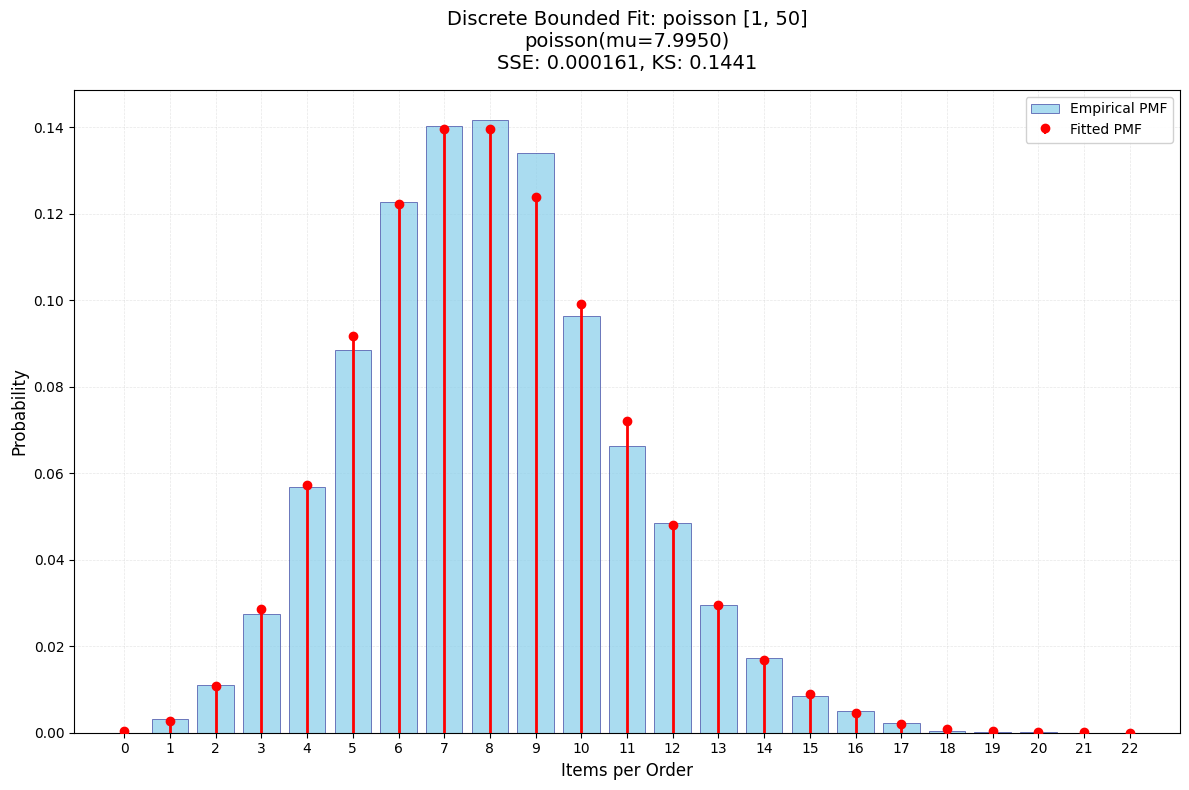

In [13]:
# Plot discrete bounded fit
fig, ax = discrete_fitter.plot(
    best_discrete,
    df_counts,
    "items_per_order",
    title=f"Discrete Bounded Fit: {best_discrete.distribution} [1, 50]",
    xlabel="Items per Order",
    ylabel="Probability",
    figsize=(12, 8),
)
plt.show()

---

# Part 3: Serialization with Bounds

Bounds are preserved when saving and loading fitted distributions.

In [14]:
import tempfile
from pathlib import Path
from spark_bestfit import DistributionFitResult

# Save bounded result
model_dir = Path(tempfile.mkdtemp())
json_path = model_dir / "bounded_model.json"

best_explicit.save(json_path)
print(f"Saved bounded model to: {json_path}")

# Load and verify bounds are preserved
loaded = DistributionFitResult.load(json_path)

print(f"\nLoaded model:")
print(f"  Distribution: {loaded.distribution}")
print(f"  Lower bound: {loaded.lower_bound}")
print(f"  Upper bound: {loaded.upper_bound}")

# Verify loaded model respects bounds
loaded_samples = loaded.sample(size=1000, random_state=42)
print(f"\nLoaded model samples: min={loaded_samples.min():.2f}, max={loaded_samples.max():.2f}")
print(f"All within bounds: {(loaded_samples >= 0).all() and (loaded_samples <= 100).all()}")

Saved bounded model to: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmpijafl5s7/bounded_model.json

Loaded model:
  Distribution: beta
  Lower bound: 0.0
  Upper bound: 100.0

Loaded model samples: min=0.92, max=80.14
All within bounds: True


In [15]:
# View JSON content to see bounds
with open(json_path) as f:
    content = f.read()

print("JSON file content (note lower_bound and upper_bound fields):")
print(content)

JSON file content (note lower_bound and upper_bound fields):
{
  "schema_version": "1.1",
  "spark_bestfit_version": "1.5.0",
  "created_at": "2026-01-01T14:44:29.088570+00:00",
  "distribution": "beta",
  "parameters": [
    2.017523765563965,
    4.732239723205566,
    -0.03554482385516167,
    95.56157684326172
  ],
  "column_name": "conversion_rate",
  "metrics": {
    "sse": 1.7056068827514537e-05,
    "aic": 82188.1796875,
    "bic": 82217.0234375,
    "ks_statistic": 0.0049279420636594296,
    "pvalue": 0.9673857092857361,
    "ad_statistic": 0.21430402994155884,
    "ad_pvalue": null
  },
  "data_summary": {
    "std": 15.720272064208984,
    "min": 0.07225889712572098,
    "sample_size": 10000.0,
    "max": 83.59192657470703,
    "mean": 28.523813247680664
  },
  "lower_bound": 0.0,
  "upper_bound": 100.0
}


In [16]:
# Cleanup
import shutil
shutil.rmtree(model_dir)
print(f"Cleaned up: {model_dir}")

Cleaned up: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/tmpijafl5s7


---

# Part 4: Real-World Examples

## 4.1 Credit Scores (300-850)

In [17]:
# Simulate credit scores
credit_scores = np.random.normal(680, 80, size=5_000)
credit_scores = np.clip(credit_scores, 300, 850)
df_credit = spark.createDataFrame([(float(x),) for x in credit_scores], ["credit_score"])

results_credit = fitter.fit(
    df_credit,
    column="credit_score",
    bounded=True,
    lower_bound=300.0,
    upper_bound=850.0,
    max_distributions=10,
)

best_credit = results_credit.best(n=1)[0]
print(f"Credit Score Model: {best_credit.distribution}")
print(f"Bounds: [{best_credit.lower_bound}, {best_credit.upper_bound}]")

# Verify samples are valid credit scores
samples = best_credit.sample(size=1000, random_state=42)
print(f"\nSample range: [{samples.min():.0f}, {samples.max():.0f}]")

Credit Score Model: beta
Bounds: [300.0, 850.0]

Sample range: [452, 848]


## 4.2 Age Data (0-120)

In [18]:
# Simulate age distribution
ages = np.random.gamma(shape=8, scale=5, size=5_000)
ages = np.clip(ages, 0, 120)
df_ages = spark.createDataFrame([(float(x),) for x in ages], ["age"])

results_age = fitter.fit(
    df_ages,
    column="age",
    bounded=True,
    lower_bound=0.0,
    upper_bound=120.0,
    max_distributions=10,
)

best_age = results_age.best(n=1)[0]
print(f"Age Model: {best_age.distribution}")
print(f"Bounds: [{best_age.lower_bound}, {best_age.upper_bound}]")

# No negative ages or unrealistic ages
samples = best_age.sample(size=1000, random_state=42)
print(f"\nSample range: [{samples.min():.1f}, {samples.max():.1f}]")

Age Model: beta
Bounds: [0.0, 120.0]

Sample range: [10.6, 97.5]


---

# Part 5: Per-Column Bounds (v1.5.0)

Starting with v1.5.0, you can specify **different bounds for each column** in multi-column fitting.

In [19]:
# Create multi-column data with different natural bounds
np.random.seed(42)

# Column 1: Percentage (0-100)
pct_data = np.random.beta(2, 5, size=3_000) * 100

# Column 2: Price (non-negative, up to ~500)
price_data = np.random.exponential(scale=50, size=3_000)

# Column 3: Age (0-120)
age_data = np.random.gamma(shape=8, scale=5, size=3_000)

df_multi = spark.createDataFrame(
    [(float(p), float(pr), float(a)) for p, pr, a in zip(pct_data, price_data, age_data)],
    ["percentage", "price", "age"]
)

print("Multi-column data with different natural bounds:")
print(f"  percentage: [{pct_data.min():.1f}, {pct_data.max():.1f}]")
print(f"  price:      [{price_data.min():.1f}, {price_data.max():.1f}]")
print(f"  age:        [{age_data.min():.1f}, {age_data.max():.1f}]")

Multi-column data with different natural bounds:
  percentage: [0.5, 82.0]
  price:      [0.0, 474.8]
  age:        [8.6, 93.9]


In [20]:
# Fit with per-column bounds using dictionaries (v1.5.0)
print("Fitting with per-column bounds...")

results_per_col = fitter.fit(
    df_multi,
    columns=["percentage", "price", "age"],
    bounded=True,
    lower_bound={
        "percentage": 0.0,    # Percentages >= 0
        "price": 0.0,         # Prices >= 0
        "age": 0.0,           # Ages >= 0
    },
    upper_bound={
        "percentage": 100.0,  # Percentages <= 100
        "price": 1000.0,      # Prices capped at $1000
        "age": 120.0,         # Ages <= 120
    },
    max_distributions=5,
)

# Check each column has its own bounds
for col in ["percentage", "price", "age"]:
    best = results_per_col.for_column(col).best(n=1)[0]
    print(f"\n{col}: {best.distribution}")
    print(f"  Bounds: [{best.lower_bound}, {best.upper_bound}]")

Fitting with per-column bounds...



percentage: beta
  Bounds: [0.0, 100.0]

price: beta
  Bounds: [0.0, 1000.0]

age: beta
  Bounds: [0.0, 120.0]


In [21]:
# Verify samples respect column-specific bounds
print("Sampling verification - each column respects its own bounds:\n")

for col, expected_bounds in [("percentage", (0, 100)), ("price", (0, 1000)), ("age", (0, 120))]:
    best = results_per_col.for_column(col).best(n=1)[0]
    samples = best.sample(size=5000, random_state=42)
    
    within = (samples >= expected_bounds[0]).all() and (samples <= expected_bounds[1]).all()
    print(f"{col}:")
    print(f"  Sample range: [{samples.min():.2f}, {samples.max():.2f}]")
    print(f"  Expected bounds: {expected_bounds}")
    print(f"  All within bounds: {within}\n")

Sampling verification - each column respects its own bounds:

percentage:
  Sample range: [0.63, 83.98]
  Expected bounds: (0, 100)
  All within bounds: True



price:
  Sample range: [0.04, 419.73]
  Expected bounds: (0, 1000)
  All within bounds: True

age:
  Sample range: [9.45, 105.35]
  Expected bounds: (0, 120)
  All within bounds: True



---

## Summary

This notebook demonstrated:

1. **Auto-detect bounds**: `bounded=True` detects bounds from data min/max

2. **Explicit bounds**: Specify `lower_bound` and/or `upper_bound` for domain knowledge

3. **Partial bounds**: Specify only one bound (e.g., prices >= 0)

4. **Sampling respects bounds**: All samples guaranteed within limits

5. **Discrete support**: `DiscreteDistributionFitter` also supports bounded fitting

6. **Serialization**: Bounds preserved when saving/loading models

7. **Per-column bounds (v1.5.0)**: Use dictionaries to specify different bounds for each column

### When to Use Bounded Fitting

| Data Type | Typical Bounds |
|-----------|---------------|
| Percentages | [0, 100] or [0, 1] |
| Prices | [0, ∞) |
| Ages | [0, 120] |
| Credit scores | [300, 850] |
| Probabilities | [0, 1] |
| Ratings | [1, 5] or [1, 10] |
| Count ranges | [min, max] |

In [22]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.
